<a href="https://colab.research.google.com/github/diogomgsimoes/DRL-Network-Path-Selection-For-Multimedia-Traffic-in-SDNs/blob/main/DRL_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RESET**

In [71]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# **IMPORTS**

In [72]:
import torch
import gym
import copy
import collections
import random
import time

import networkx as nx
import numpy as np
import torch.multiprocessing as mp
import tensorflow as tf

from itertools import islice, count
from gym import Env
from gym.spaces import Discrete, Box
from matplotlib import pylab as plt
from collections import deque
from torch.nn import functional as F
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR

# **GLOBAL VARIABLES**

In [73]:
TOPOLOGY_ARPANET_FILE_NAME = 'topology_ARPANET.txt'
NUMBER_OF_HOSTS = 13
NUMBER_OF_PATHS = 5
REWARD_SCALE = NUMBER_OF_HOSTS * NUMBER_OF_HOSTS * NUMBER_OF_PATHS

# **DRLEngine: Manages the environment**

In [65]:
class DRLEngine():
    def __init__(self):
        self.graph = nx.Graph()
        self.link_bw_capacity = {}
        self.current_link_bw = {}
        self.hosts = {}
        self.paths = {}
        self.host_pairs = [('H1', 'H13'), ('H2', 'H9'), ('H4', 'H10'), ('H3', 'H6'), ('H5', 'H4'), ('H3', 'H12'), ('H1', 'H7'), ('H7', 'H4'),
                            ('H1', 'H8'), ('H2', 'H5'), ('H4', 'H13'), ('H3', 'H4'), ('H5', 'H12'), ('H3', 'H9'), ('H1', 'H5'), ('H7', 'H13')]
        self.requests_bw = [5, 10, 15, 20]

        self.upload_topology()
        self.build_graph()
        self.calculate_paths()

    def upload_topology(self):
        with open(TOPOLOGY_ARPANET_FILE_NAME, 'r') as topo:
            for row in topo.readlines():
                row_data = row.split()
                if 'H' in row_data[0]:
                    self.hosts[row_data[0]] = row_data[1].replace("S", "")
                elif 'S' in row_data[0]:
                    src_id = row_data[0].replace("S", "")
                    dst_id = row_data[1].replace("S", "")
                    self.link_bw_capacity[(src_id, dst_id)] = int(row_data[2])
                    self.link_bw_capacity[(dst_id, src_id)] = int(row_data[2])

        self.current_link_bw = copy.deepcopy(self.link_bw_capacity)

    def build_graph(self):
        with open(TOPOLOGY_ARPANET_FILE_NAME, 'r') as topo:
            for line in topo.readlines():
                nodes = line.split()[:2]
                for node in nodes:
                    if not self.graph.has_node(node):
                        self.graph.add_node(node)
                self.graph.add_edge(nodes[0], nodes[1])
    
    def k_shortest_paths(self, graph, source, target, k):
        try: 
            calc = list(islice(nx.shortest_simple_paths(graph, source, target), k))
        except nx.NetworkXNoPath:
            calc = []
            
        return [path for path in calc]

    def calculate_paths(self):
        for src_host_id in range(1, NUMBER_OF_HOSTS+1):
            src = "H{}".format(src_host_id)
            for dst_host_id in range(1, NUMBER_OF_HOSTS+1):
                dst = "H{}".format(dst_host_id)
                if self.graph.has_node(src) and self.graph.has_node(dst):
                    self.paths[(src, dst)] = self.k_shortest_paths(self.graph, src, dst, NUMBER_OF_PATHS)
                    for path in self.paths[(src, dst)]:
                        if len(path) != 0:
                            for i in range(0, len(path)):
                                if "S" in path[i]:
                                    path[i] = path[i].replace("S", "")
                                    path[i] = int(path[i])

    def make_reservation(self, path_id, delay):
        time.sleep(delay)
        random.shuffle(self.host_pairs)
        pair = self.host_pairs.pop(0)
        path = self.paths[(pair[0], pair[1])][path_id][1:-1]
        request_bw = 15
        # request_bw = self.requests_bw[random.randint(0, 3)]

        for s1, s2 in zip(path[:-1], path[1:]):
            if self.current_link_bw.get((str(s1), str(s2))):
                self.current_link_bw[(str(s1), str(s2))] -= request_bw
                if self.current_link_bw[(str(s1), str(s2))] == 0:
                    self.current_link_bw[(str(s1), str(s2))] = 1
            if self.current_link_bw.get((str(s2), str(s1))):
                self.current_link_bw[(str(s2), str(s1))] -= request_bw
                if self.current_link_bw[(str(s2), str(s1))] == 0:
                    self.current_link_bw[(str(s2), str(s1))] = 1


    def build_state(self):
        state = np.empty((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), dtype=object)
        
        for src in range(1, NUMBER_OF_HOSTS+1):
            h_src = "H{}".format(src)
            for dst in range(1, NUMBER_OF_HOSTS+1):
                h_dst = "H{}".format(dst)
                min_value = float('Inf')
                cnt = 0
                if len(self.paths[(h_src, h_dst)]) == 1:
                    if self.paths[(h_src, h_dst)] == []:
                        for idx in range(NUMBER_OF_PATHS):
                            state[src-1, dst-1, idx] = 1
                    else: 
                        state[src-1, dst-1, 0] = 100
                        for idx in range(1, NUMBER_OF_PATHS):
                            state[src-1, dst-1, idx] = 1
                else:
                    for path in self.paths[(h_src, h_dst)]:
                        path = path[1:-1]
                        for s1, s2 in zip(path[:-1], path[1:]):
                            stats = self.current_link_bw.get((str(s1), str(s2)))
                            if stats:
                                if float(stats) < float(min_value):
                                    min_value = self.current_link_bw[(str(s1), str(s2))]
                    
                        state[src-1, dst-1, cnt] = float(min_value)
                        cnt += 1
                        
                    for idx in range(len(self.paths[(h_src, h_dst)]), NUMBER_OF_PATHS):
                        state[src-1, dst-1, idx] = 1
                    
        return state

    def reset(self):
        self.graph = nx.Graph()
        self.host_pairs = [('H1', 'H13'), ('H2', 'H9'), ('H4', 'H10'), ('H3', 'H6'), ('H5', 'H4'), ('H3', 'H12'), ('H1', 'H7'), ('H7', 'H4'),
                           ('H1', 'H8'), ('H2', 'H5'), ('H4', 'H13'), ('H3', 'H4'), ('H5', 'H12'), ('H3', 'H9'), ('H1', 'H5'), ('H7', 'H13')]
        self.current_link_bw = copy.deepcopy(self.link_bw_capacity)

In [66]:
# Get "The load centrality of a node is the fraction of all shortest paths that pass through that node."

# engine = DRLEngine()
# node_centrality = nx.load_centrality(engine.graph)
# edge_centrality = nx.edge_load_centrality(engine.graph)
# print(edge_centrality)

# **RoutingEnv: Environment**

In [67]:
class RoutingEnv(Env):
    def __init__(self):
        self.requests = 0
        # self.max_requests = random.randint(1, 16)
        self.max_requests = 16
        self.done = False

        self.engine = DRLEngine()

        self.observation_space = Box(low=np.zeros((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), dtype=np.float32), \
            high=np.full((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), 100, dtype=np.float32), dtype=np.float32)
        
        self.action_space = Discrete(NUMBER_OF_PATHS)
        self.state = np.full((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), 100, dtype=np.float32)

    def step(self, action):
        self.engine.make_reservation(action, np.random.poisson(3))
        self.requests += 1
        
        reward = 0
        self.state = self.engine.build_state()

        for src in range(NUMBER_OF_HOSTS):
            for dst in range(NUMBER_OF_HOSTS):
                for path_number in range(NUMBER_OF_PATHS):
                    bw = self.state[src, dst, path_number]
                    if bw != None:
                        if bw > 75:
                            reward += 20
                        elif bw > 50: 
                            reward += 10
                        elif bw > 25: 
                            pass
                        elif bw > 0: 
                            reward -= 10
                        else:
                            reward -= 50

        if self.requests == self.max_requests:
            self.done = True
        
        return self.state, reward/REWARD_SCALE, self.done, {}

    def render(self):
        pass

    def get_state(self):
        return self.state

    def reset(self):
        self.done = False
        self.state = np.full((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), 100, dtype=np.float32)
        self.requests = 0
        # self.max_requests = random.randint(1, 16)
        self.engine.reset()

        return self.state

**Test environment**

In [68]:
# env = RoutingEnv()
# episodes = 10

# for episode in range(1, episodes + 1):
#     env.reset()
#     done = False
#     score = 0

#     while not done:
#         n_state, reward, done, info = env.step(random.randint(0, 4))
#         score += reward

#     print('Episode: {}, Score: {}'.format(episode, score))

# **DQN with experience replay and a target network for stability**

A saída de streaming foi truncada nas últimas 5000 linhas.
Step: 14
4731 8.711766242980957
Episode reward: 151.6923076923077
Starting training, epoch: 4732
Step: 1
4732 9.343792915344238
Episode reward: 18.153846153846153
Starting training, epoch: 4733
Step: 1
4733 7.9321699142456055
Step: 2
4733 6.891098499298096
Step: 3
4733 8.506261825561523
Step: 4
4733 8.275497436523438
Step: 5
4733 7.821714878082275
Step: 6
4733 12.20903205871582
Step: 7
4733 8.842613220214844
Episode reward: 106.52071005917158
Starting training, epoch: 4734
Step: 1
4734 7.314734935760498
Step: 2
4734 8.29197883605957
Step: 3
4734 9.618035316467285
Episode reward: 54.46153846153846
Starting training, epoch: 4735
Step: 1
4735 8.394174575805664
Step: 2
4735 10.207093238830566
Step: 3
4735 11.431779861450195
Step: 4
4735 10.342297554016113
Step: 5
4735 9.02480697631836
Step: 6
4735 7.497139930725098
Step: 7
4735 7.006938457489014
Episode reward: 116.88757396449705
Starting training, epoch: 4736
Step: 1
4736 9.158973

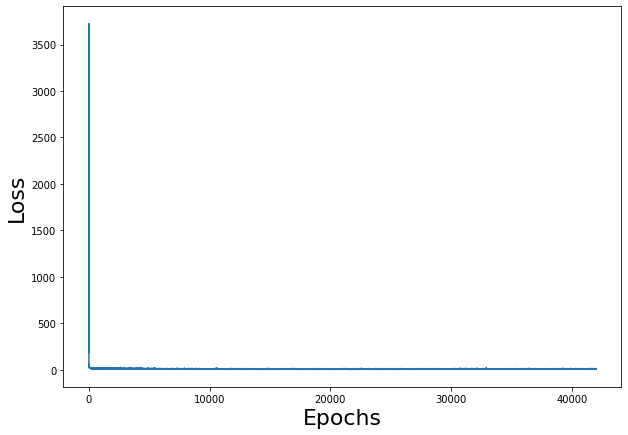

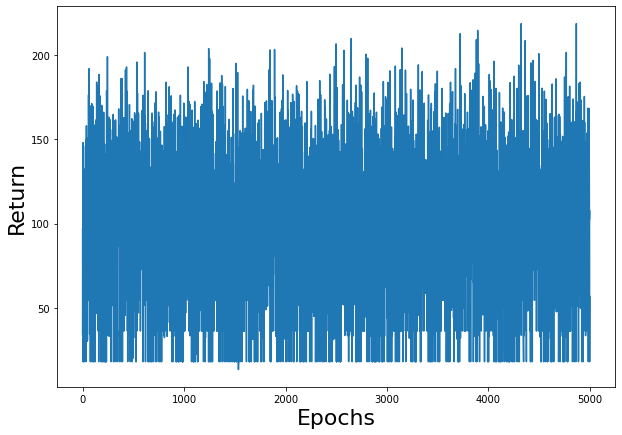

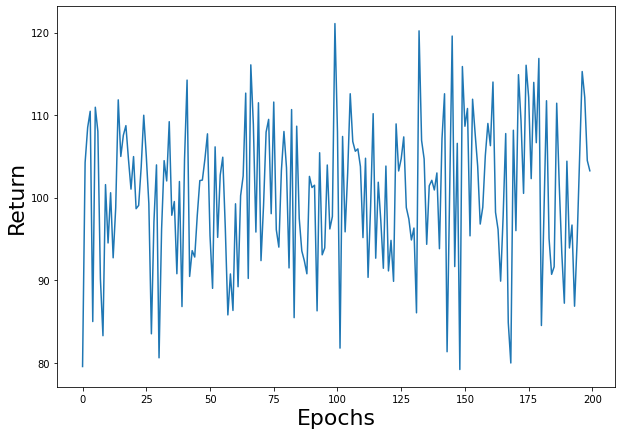

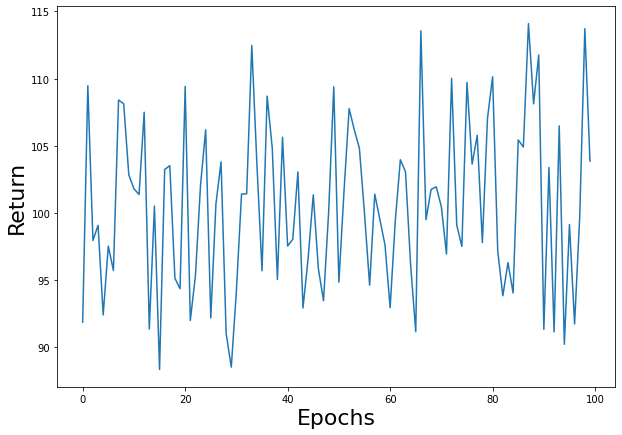

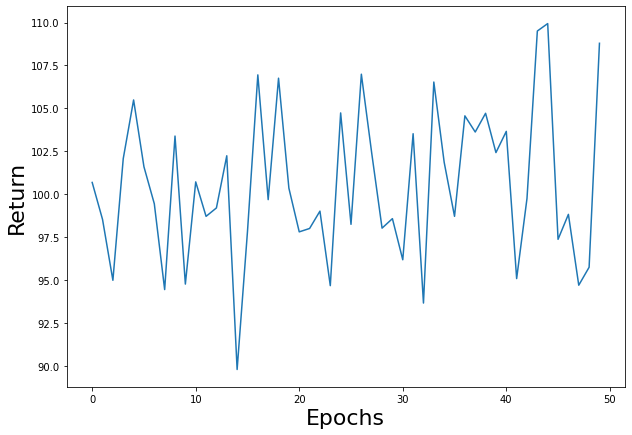

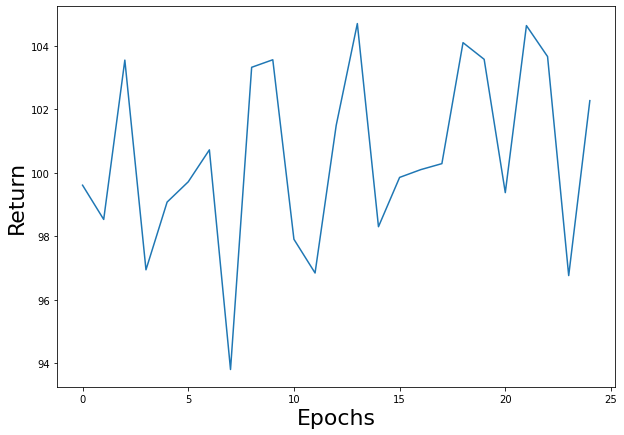

In [ ]:
# Functional DQN Agent with Experience Replay and Target Network

env = RoutingEnv()

# l1 = 320
# l2 = 500
# l3 = 800
# l4 = 400
# l5 = 200
# l6 = 50
# l7 = 5

l1 = 845
l2 = 1500
l3 = 700
l4 = 200
l5 = 5

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4),
    torch.nn.ReLU(),
    torch.nn.Linear(l4, l5)
)

# l1 = 320
# l2 = 160
# l3 = 80
# l4 = 5

# model = torch.nn.Sequential(
#     torch.nn.Linear(l1, l2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(l2, l3),
#     torch.nn.ReLU(),
#     torch.nn.Linear(l3,l4)
# )

model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

gamma = 0.9
epsilon = 0.5
learning_rate = 1e-3

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# state_flattened_size = 320
state_flattened_size = 845
losses = []
total_reward_list = []
epochs = 5000
mem_size = 50000
batch_size = 256
sync_freq = 50
replay = deque(maxlen=mem_size)

for i in range(epochs):
    print("Starting training, epoch:", i)
    cnt = 0
    total_reward = 0
    _state = env.get_state()
    state1 = torch.flatten(torch.from_numpy(_state.astype(np.float32))).reshape(1, state_flattened_size)
    done = False
    env.reset()
    
    while not done: 
        print("Step:", cnt+1)
        cnt += 1
        qval = model(state1) 
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        state, reward, done, _ = env.step(action_)
        state2 = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1,state_flattened_size)
        
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch)
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if cnt % sync_freq == 0:
                model2.load_state_dict(model.state_dict())
        
        total_reward += reward
    
    total_reward_list.append(total_reward)
    print("Episode reward:", total_reward)
        
    if epsilon > 0.05:
        epsilon -= (1/epochs)
        
print(total_reward_list)
   
print('Plotting losses ...')     
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.savefig('avg_loss.png') 

print('Plotting rewards ...')     
plt.figure(figsize=(10,7))
plt.plot(total_reward_list)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Return",fontsize=22)
plt.savefig('avg_return.png')

sizes = [25, 50, 100, 200]
for size in sizes:
    avg = []
    for idx in range(0, len(total_reward_list), size):
        avg += [sum(val for val in total_reward_list[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.plot(avg)
    plt.xlabel("Epochs",fontsize=22)
    plt.ylabel("Return",fontsize=22)
    plt.savefig('avg_return_{}.png'.format(size))

torch.save(model.state_dict(), 'dqn_model_exp_replay_target_network.pt')

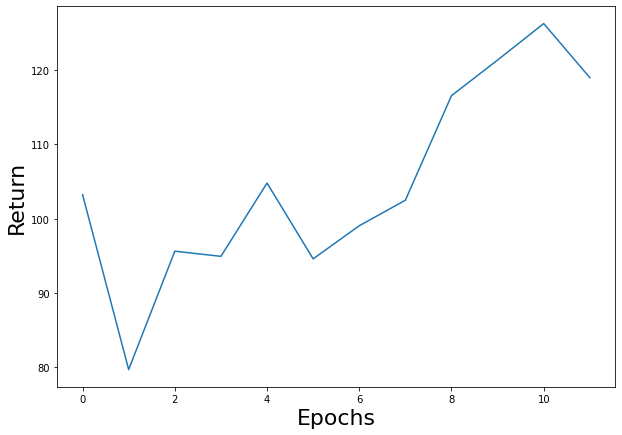

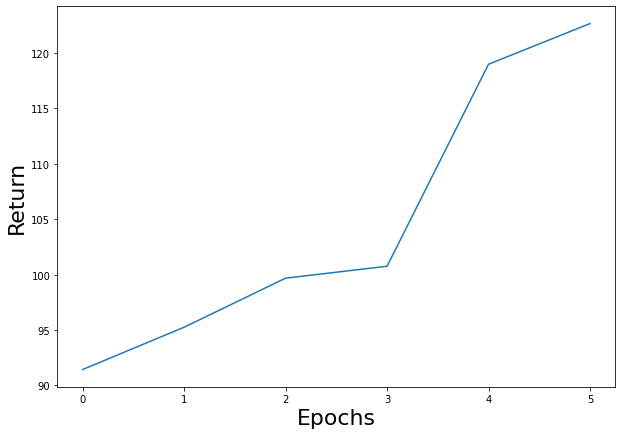

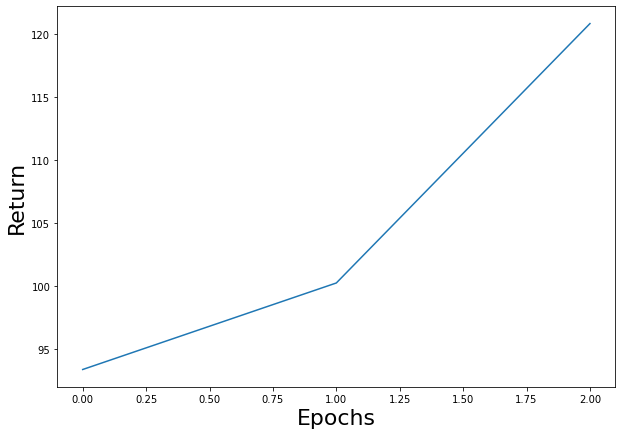

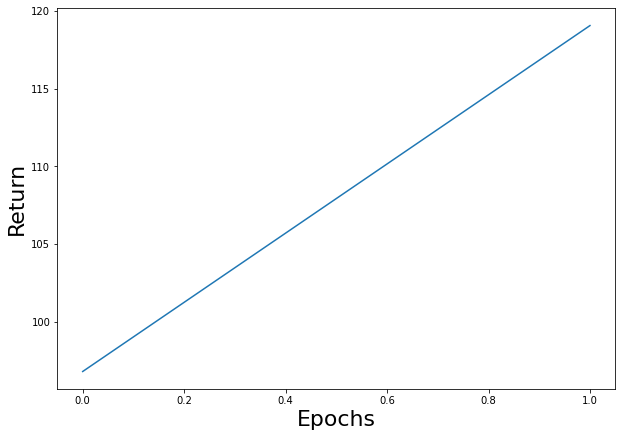

In [70]:
sizes = [25, 50, 100, 200]
total_reward_list = [115.71597633136096, 72.93491124260355, 115.7041420118343, 103.0414201183432, 123.89349112426036, 122.3550295857988, 85.19526627218934, 123.396449704142, 122.93491124260355, 102.73372781065086, 94.46153846153848, 150.61538461538464, 133.42011834319527, 86.13017751479288, 89.15976331360947, 116.56804733727812, 121.84615384615384, 122.34319526627216, 79.63313609467454, 36.07100591715975, 119.88165680473374, 77.11242603550296, 97.78698224852073, 26.946745562130182, 140.91124260355028, 24.63905325443788, 56.37869822485207, 87.70414201183434, 53.60946745562132, 147.92899408284023, 95.82248520710063, 4.792899408284022, 101.85798816568045, 14.011834319526614, 101.50295857988166, 101.53846153846155, 112.05917159763314, 101.38461538461539, 70.69822485207102, 97.45562130177514, 80.54437869822485, 96.84023668639055, 112.37869822485209, 43.23076923076923, 101.96449704142012, 22.236686390532533, 112.86390532544381, 104.01183431952661, 124.42603550295856, 21.26627218934908, 90.46153846153848, 141.42011834319524, 72.59171597633136, 52.66272189349113, 85.2544378698225, 99.1242603550296, 136.60355029585799, 100.78106508875739, 112.49704142011834, 82.4260355029586, 49.763313609467446, 106.66272189349112, 104.53254437869822, 109.78698224852073, 125.00591715976331, 105.63313609467454, 114.46153846153851, 112.01183431952663, 93.26627218934911, 99.59763313609466, 60.27218934911241, 115.84615384615384, 56.899408284023664, 61.18343195266272, 101.27810650887574, 92.189349112426, 63.502958579881664, 51.77514792899407, 93.89349112426038, 148.8994082840236, 114.60355029585799, 106.91124260355029, 61.91715976331361, 94.03550295857987, 109.81065088757398, 81.8224852071006, 122.7455621301775, 124.53254437869823, 44.73372781065092, 93.52662721893493, 43.10059171597632, 98.62721893491124, 89.63313609467455, 110.89940828402366, 118.41420118343193, 130.6153846153846, 106.72189349112428, 108.85207100591714, 50.11834319526626, 110.85207100591715, 88.0473372781065, 115.42011834319528, 112.40236686390531, 107.17159763313609, 106.69822485207102, 104.72189349112426, 116.80473372781069, 151.13609467455623, 87.36094674556212, 57.136094674556205, 95.42011834319526, 133.52662721893486, 142.80473372781069, 94.62721893491124, 119.6923076923077, 74.63905325443784, 112.41420118343196, 130.5680473372781, 104.69822485207101, 135.0769230769231, 108.62721893491124, 19.810650887573953, 127.53846153846158, 97.6094674556213, 75.84615384615384, 135.47928994082844, 84.93491124260353, 88.72189349112428, 25.90532544378698, 104.93491124260352, 54.6627218934911, 84.74556213017752, 118.41420118343196, 113.8224852071006, 66.27218934911244, 89.96449704142015, 159.15976331360946, 107.23076923076921, 162.8639053254437, 106.80473372781067, 91.44378698224854, 94.98224852071006, 143.02958579881656, 57.37278106508876, 87.24260355029587, 59.90532544378698, 106.63905325443787, 11.715976331360945, 138.67455621301775, 69.3609467455621, 94.33136094674558, 91.6568047337278, 122.01183431952661, 107.18343195266272, 103.14792899408282, 97.07692307692307, 130.3786982248521, 17.420118343195266, 155.56213017751477, 100.78106508875742, 93.56213017751479, 137.01775147928998, 121.1834319526627, 83.20710059171599, 117.95266272189352, 109.43195266272188, 91.34911242603552, 107.2189349112426, 119.37278106508876, 102.59171597633137, 30.733727810650862, 25.45562130177513, 121.98816568047337, 118.16568047337275, 77.06508875739644, 139.20710059171594, 154.67455621301775, 112.74556213017756, 90.05917159763312, 90.22485207100591, 65.58579881656806, 98.52071005917159, 62.54437869822484, 137.27810650887577, 51.42011834319527, 86.50887573964496, 27.526627218934912, 105.02958579881658, 100.98224852071004, 121.12426035502962, 114.85207100591715, 129.91715976331363, 91.38461538461537, 86.98224852071007, 74.92307692307689, 116.91124260355028, 109.51479289940825, 130.65088757396452, 130.33136094674555, 133.06508875739644, 136.11834319526625, 123.6804733727811, 130.53254437869825, 102.01183431952663, 135.89349112426035, 124.31952662721893, 114.2248520710059, 155.88165680473372, 106.73372781065092, 124.13017751479288, 160.71005917159763, 144.01183431952663, 110.79289940828401, 81.46745562130178, 137.26627218934914, 69.11242603550295, 124.02366863905326, 123.42011834319526, 52.272189349112416, 131.75147928994082, 110.74556213017752, 120.7810650887574, 139.28994082840237, 81.33727810650886, 74.01183431952664, 104.30769230769232, 108.11834319526628, 91.27810650887574, 152.48520710059168, 125.76331360946745, 116.09467455621302, 146.97041420118344, 112.01183431952664, 133.396449704142, 109.38461538461539, 130.50887573964496, 86.6627218934911, 108.698224852071, 165.9644970414201, 119.26627218934911, 54.84023668639054, 127.7396449704142, 162.39053254437871, 92.80473372781067, 132.1775147928994, 144.60355029585796, 119.26627218934911, 141.00591715976333, 131.26627218934914, 117.73964497041422, 146.99408284023664, 68.7810650887574, 129.9526627218935, 157.11242603550292, 40.44970414201184, 132.23668639053253, 118.49704142011834, 108.84023668639053, 124.01183431952663, 136.2130177514793, 129.24260355029585, 154.8402366863905, 135.0887573964497, 144.8520710059172, 126.47337278106514, 127.94082840236686, 163.9644970414201, 142.41420118343197, 102.00000000000003, 114.14201183431955, 164.0710059171597, 113.55029585798816, 128.85207100591717, 110.93491124260355, 136.1301775147929, 123.66863905325442, 122.71005917159766, 52.331360946745576, 115.91715976331363, 145.78698224852073, 138.15384615384616, 143.8224852071006, 55.076923076923094, 118.85207100591713, 147.85798816568047, 113.17159763313607, 149.82248520710058, 120.86390532544378, 128.792899408284, 166.00000000000006, 129.96449704142012, 138.17751479289942, 127.7396449704142, 104.84023668639053, 112.69822485207101, 74.52071005917159, 126.93491124260353, 97.18343195266273, 132.4378698224852, 87.86982248520708, 101.66863905325442, 103.11242603550296, 141.59763313609466, 107.56213017751479, 104.20118343195266, 130.4023668639053, 148.94674556213022, 59.6449704142012, 134.44970414201185, 139.11242603550292, 124.07100591715977, 145.1479289940829, 92.9230769230769, 118.39053254437869, 97.83431952662721, 74.31952662721892, 158.02366863905323, 98.65088757396451, 142.30769230769235, 111.06508875739644, 71.8816568047337, 149.83431952662718, 59.50295857988164, 123.63313609467455, 141.68047337278108, 131.43195266272187, 144.01183431952666, 100.20118343195266, 134.89940828402362, 136.2130177514793, 94.42603550295854, 81.17159763313609, 73.77514792899409, 55.97633136094673, 79.37278106508876, 116.2130177514793, 134.5798816568047, 160.5680473372781, 124.53254437869825, 129.42011834319524, 157.4319526627219, 155.33727810650888, 68.3905325443787, 108.50887573964496, 116.09467455621301, 78.29585798816568, 147.68047337278108, 105.83431952662723, 91.85798816568045, 152.00000000000003, 132.23668639053253, 135.40828402366867, 133.94082840236686, 155.96449704142015, 127.40828402366864, 139.95266272189346, 125.96449704142013, 146.75739644970412, 114.16568047337279, 135.56213017751475, 99.47928994082841, 124.85207100591717, 37.692307692307686, 90.87573964497042, 94.20118343195263, 108.50887573964496, 129.63313609467454, 107.72781065088758, 158.6508875739645, 113.00591715976334, 90.53254437869822, 127.10059171597632, 158.03550295857988, 64.49704142011834, 134.40236686390534, 129.90532544378695, 128.03550295857988, 137.44378698224853, -31.988165680473383, 156.84023668639057, 144.2130177514793, 168.60355029585796, 153.7396449704142, 160.62721893491124, 37.57396449704143, 122.65088757396448, 117.32544378698223, 128.26035502958578, 106.03550295857987, 143.63313609467457, 144.95857988165682, 105.45562130177512, 153.37278106508873, 158.1301775147929, 121.47928994082841, 79.57396449704142, 81.81065088757396, 104.30769230769229, 101.8816568047337, 129.8698224852071]

for size in sizes:
    avg = []
    for idx in range(0, len(total_reward_list[:-100]), size):
        avg += [sum(val for val in total_reward_list[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.plot(avg)
    plt.xlabel("Epochs",fontsize=22)
    plt.ylabel("Return",fontsize=22)
    plt.savefig('avg_return_{}.png'.format(size))

**Test DQN**

In [ ]:
def test_model(model):
    test_env = RoutingEnv()
    _state = test_env.reset()
    state = torch.flatten(torch.from_numpy(_state.astype(np.float32))).reshape(1,320)
    done = False
    rewards = []
    while not done:
        qval = model(state)
        qval_ = qval.data.numpy()
        action = np.argmax(qval_)
        _state, reward, done, _ = test_env.step(action)
        print("Action:", action)
        print("Done:", done)
        state = torch.flatten(torch.from_numpy(_state.astype(np.float32))).reshape(1,320)
        rewards.append(reward)
    print("Reward sum:", sum(rewards))

In [ ]:
# Model loading and testing

l1 = 320
l2 = 160
l3 = 80
l4 = 5

model_test = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

model_test.load_state_dict(torch.load("dqn_model_exp_replay_target_network.pt"))
test_model(model_test)

# **Double DQN**

Episode:  0
rewards:  104.10650887573964
lr:  0.001
eps:  1
Episode:  1
rewards:  104.56804733727812
lr:  0.001
eps:  0.995


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


A saída de streaming foi truncada nas últimas 5000 linhas.
eps:  0.01
Episode:  4751
rewards:  18.153846153846153
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4752
rewards:  90.57988165680473
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4753
rewards:  77.97633136094676
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4754
rewards:  82.76923076923076
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4755
rewards:  151.49112426035504
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4756
rewards:  47.66863905325444
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4757
rewards:  151.0414201183432
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4758
rewards:  142.48520710059174
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4759
rewards:  67.07692307692308
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4760
rewards:  18.153846153846153
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4761
rewards:  129.11242603550295
lr:  7.069650490151056e-06
eps:  0.01
Episode:  4762
rewards:  126.98224

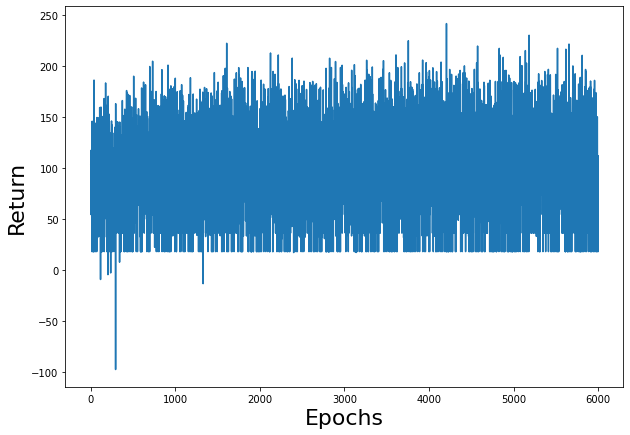

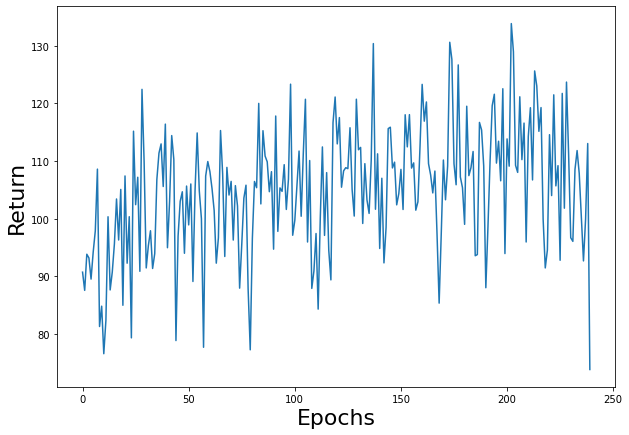

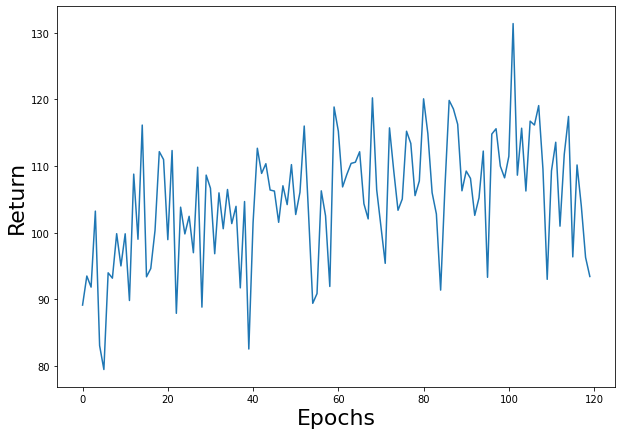

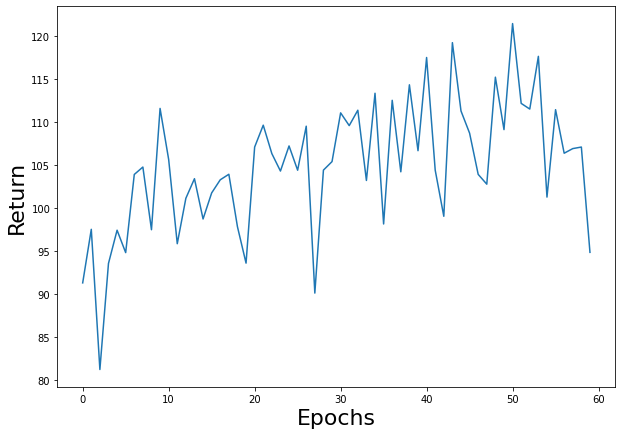

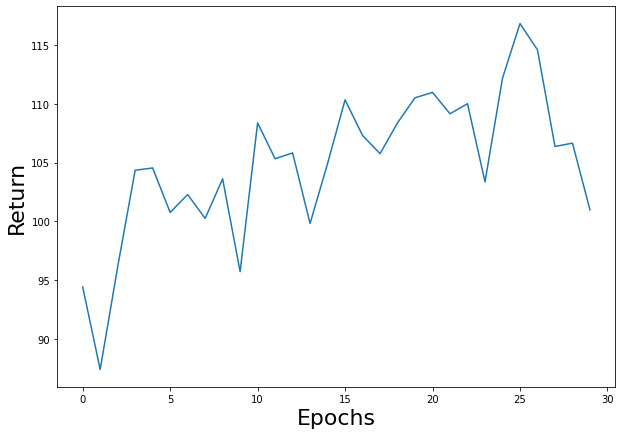

In [ ]:
total_rewards = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    def __init__(self, action_dim, state_dim, hidden_dim):
        super(QNetwork, self).__init__()

        self.fc_1 = nn.Linear(845, 1500)
        self.fc_2 = nn.Linear(1500, 700)
        self.fc_3 = nn.Linear(700, 200)
        self.fc_4 = nn.Linear(200, action_dim)

    def forward(self, inp):

        x1 = F.leaky_relu(self.fc_1(inp))
        x1 = F.leaky_relu(self.fc_2(x1))
        x1 = F.leaky_relu(self.fc_3(x1))
        x1 = self.fc_4(x1)

        return x1

class Memory:
    def __init__(self, len):
        self.rewards = collections.deque(maxlen=len)
        self.state = collections.deque(maxlen=len)
        self.action = collections.deque(maxlen=len)
        self.is_done = collections.deque(maxlen=len)

    def update(self, state, action, reward, done):
        # if the episode is finished we do not save to new state. Otherwise we have more states per episode than rewards
        # and actions whcih leads to a mismatch when we sample from memory.
        if not done:
            self.state.append(state)
        self.action.append(action)
        self.rewards.append(reward)
        self.is_done.append(done)

    def sample(self, batch_size):
        """
        sample "batch_size" many (state, action, reward, next state, is_done) datapoints.
        """
        n = len(self.is_done)
        idx = random.sample(range(0, n-1), batch_size)

        return torch.Tensor(self.state)[idx].to(device), torch.LongTensor(self.action)[idx].to(device), \
               torch.Tensor(self.state)[1+np.array(idx)].to(device), torch.Tensor(self.rewards)[idx].to(device), \
               torch.Tensor(self.is_done)[idx].to(device)

    def reset(self):
        self.rewards.clear()
        self.state.clear()
        self.action.clear()
        self.is_done.clear()


def select_action(model, env, state, eps):
    _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1, 845)
    state = _state.to(device)
    
    with torch.no_grad():
        values = model(state)

    # select a random action wih probability eps
    if random.random() <= eps:
        action = np.random.randint(0, env.action_space.n)
    else:
        action = np.argmax(values.cpu().numpy())

    return action


def train(batch_size, current, target, optim, memory, gamma):

    states, actions, next_states, rewards, is_done = memory.sample(batch_size)
    
    _states = states.reshape(256, 845)
    _next_states = next_states.reshape(256, 845)

    q_values = current(_states)

    next_q_values = current(_next_states)
    next_q_state_values = target(_next_states)

    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = rewards + gamma * next_q_value * (1 - is_done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()


def evaluate(Qmodel, env, repeats):
    """
    Runs a greedy policy with respect to the current Q-Network for "repeats" many episodes. Returns the average
    episode reward.
    """
    Qmodel.eval()
    perform = 0
    for _ in range(repeats):
        state = env.reset()
        done = False
        while not done:
            _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1, 845).to(device)
            with torch.no_grad():
                values = Qmodel(_state)
            action = np.argmax(values.cpu().numpy())
            state, reward, done, _ = env.step(action)
            perform += reward
    Qmodel.train()
    return perform/repeats

def update_parameters(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())


def main(gamma=0.99, lr=1e-3, min_episodes=2, eps=1, eps_decay=0.995, eps_min=0.01, update_step=50, batch_size=256, update_repeats=16,
         num_episodes=6000, seed=42, max_memory_size=500000, lr_gamma=0.9, lr_step=100, measure_step=1,
         measure_repeats=1, hidden_dim=160, env_name='DRL_Mininet-v0', cnn=False, horizon=np.inf, render=False, render_step=50):
    
    global total_rewards
    """
    :param gamma: reward discount factor
    :param lr: learning rate for the Q-Network
    :param min_episodes: we wait "min_episodes" many episodes in order to aggregate enough data before starting to train
    :param eps: probability to take a random action during training
    :param eps_decay: after every episode "eps" is multiplied by "eps_decay" to reduces exploration over time
    :param eps_min: minimal value of "eps"
    :param update_step: after "update_step" many episodes the Q-Network is trained "update_repeats" many times with a
    batch of size "batch_size" from the memory.
    :param batch_size: see above
    :param update_repeats: see above
    :param num_episodes: the number of episodes played in total
    :param seed: random seed for reproducibility
    :param max_memory_size: size of the replay memory
    :param lr_gamma: learning rate decay for the Q-Network
    :param lr_step: every "lr_step" episodes we decay the learning rate
    :param measure_step: every "measure_step" episode the performance is measured
    :param measure_repeats: the amount of episodes played in to asses performance
    :param hidden_dim: hidden dimensions for the Q_network
    :param env_name: name of the gym environment
    :param cnn: set to "True" when using environments with image observations like "Pong-v0"
    :param horizon: number of steps taken in the environment before terminating the episode (prevents very long episodes)
    :param render: if "True" renders the environment every "render_step" episodes
    :param render_step: see above
    :return: the trained Q-Network and the measured performances
    """
    env = RoutingEnv()
    torch.manual_seed(seed)
    env.seed(seed)

    if cnn:
        Q_1 = QNetwork(action_dim=env.action_space.n).to(device)
        Q_2 = QNetwork(action_dim=env.action_space.n).to(device)
    else:
        Q_1 = QNetwork(action_dim=env.action_space.n, state_dim=env.observation_space.shape[0],
                                        hidden_dim=hidden_dim).to(device)
        Q_2 = QNetwork(action_dim=env.action_space.n, state_dim=env.observation_space.shape[0],
                                        hidden_dim=hidden_dim).to(device)
    # transfer parameters from Q_1 to Q_2
    update_parameters(Q_1, Q_2)

    # we only train Q_1
    for param in Q_2.parameters():
        param.requires_grad = False

    optimizer = torch.optim.Adam(Q_1.parameters(), lr=lr)
    optimizer.step()
    scheduler = StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)

    memory = Memory(max_memory_size)
    performance = []

    for episode in range(num_episodes):
        # display the performance
        if episode % measure_step == 0:
            performance.append([episode, evaluate(Q_1, env, measure_repeats)])
            print("Episode: ", episode)
            print("rewards: ", performance[-1][1])
            total_rewards.append(performance[-1][1])
            print("lr: ", scheduler.get_last_lr()[0])
            print("eps: ", eps)

        state = env.reset()
        # _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1,320)
        memory.state.append(state.reshape(1, 845))

        done = False
        i = 0
        while not done:
            i += 1
            action = select_action(Q_2, env, state, eps)
            state, reward, done, _ = env.step(action)
            
            # _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1,320)

            if i > horizon:
                done = True

            # render the environment if render == True
            if render and episode % render_step == 0:
                env.render()

            # save state, action, reward sequence
            memory.update(state.reshape(1, 845), action, reward, done)

        if episode >= min_episodes and episode % update_step == 0:
            for _ in range(update_repeats):
                train(batch_size, Q_1, Q_2, optimizer, memory, gamma)

            # transfer new parameter from Q_1 to Q_2
            update_parameters(Q_1, Q_2)

        # update learning rate and eps
        scheduler.step()
        eps = max(eps*eps_decay, eps_min)

    print(performance)
    return Q_1, performance

Q_1, performance = main()
torch.save(Q_1.state_dict(), "ddqn_model_16_random_requests")
print(total_rewards)
print("Plotting rewards...")
plt.figure(figsize=(10,7))
plt.plot(total_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Return",fontsize=22)
plt.savefig('avg_return.png')

sizes = [25, 50, 100, 200]
for size in sizes:
    avg = []
    for idx in range(0, len(total_rewards), size):
        avg += [sum(val for val in total_rewards[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.plot(avg)
    plt.xlabel("Epochs",fontsize=22)
    plt.ylabel("Return",fontsize=22)
    plt.savefig('avg_return_{}.png'.format(size))

In [ ]:
# ddqn_20 = [-0.5833333333333334, -43.666666666666664, 7.333333333333333, 27.333333333333332, 22.166666666666668, 6.916666666666667, 9.5, 22.833333333333332, 8.833333333333334, 3.6666666666666665, -26.666666666666668, 15.166666666666666, 28.916666666666668, 25.083333333333332, 29.0, 27.25, 23.75, 22.666666666666668, 21.583333333333332, 11.416666666666666, 19.083333333333332, 32.75, 22.666666666666668, -5.416666666666667, 11.666666666666666, 35.0, 20.75, 25.5, 20.5, 31.75, 21.583333333333332, 18.666666666666668, 26.833333333333332, 23.166666666666668, 34.75, -0.9166666666666666, 19.416666666666668, 23.0, 25.666666666666668, 24.5, -12.333333333333334, 30.583333333333332, 16.333333333333332, 13.833333333333334, 40.916666666666664, 37.75, 24.416666666666668, 17.833333333333332, 24.583333333333332, 40.333333333333336, 39.416666666666664, 13.75, 0.5, 21.916666666666668, 23.833333333333332, 23.583333333333332, 28.0, 26.416666666666668, 34.5, 29.583333333333332, 27.5, 20.833333333333332, 18.666666666666668, 22.666666666666668, 19.833333333333332, 16.833333333333332, 22.083333333333332, 18.666666666666668, 15.083333333333334, 20.666666666666668, 25.0, 40.0, 25.75, 41.75, 44.5, 16.75, 40.333333333333336, 26.25, 15.25, 24.833333333333332, 28.833333333333332, 44.333333333333336, 12.166666666666666, 11.5, 22.916666666666668, 7.833333333333333, 37.666666666666664, 38.416666666666664, 20.416666666666668, 19.666666666666668, 46.666666666666664, 14.833333333333334, 36.583333333333336, 24.666666666666668, 28.333333333333332, 46.083333333333336, 4.833333333333333, 21.083333333333332, 43.75, 28.916666666666668]
# dqn = [6.75, 22.0, -23.75, 28.0, 21.0, 6.75, 31.25, -1.5, -8.0, 14.0, 1.75, 36.25, 23.25, 12.25, -10.5, 20.0, 34.5, 6.0, -35.5, 22.75, 24.25, -67.25, 7.5, -1.25, 14.0, 12.75, 23.75, 28.0, 32.0, 30.75, -30.0, 26.25, -32.75, 22.0, 48.75, -32.25, 36.25, 6.5, -99.75, 14.5, -1.75, 31.75, 3.5, -29.75, 43.25, 34.5, 35.25, -30.5, -1.0, 27.0, 6.5, 8.25, 27.0, 42.75, 0.5, -20.25, 22.5, 9.5, 28.0, 5.5, 35.0, 37.0, 8.5, 49.25, 14.0, 16.5, 54.0, 13.0, 14.0, 13.0, 24.5, 34.25, 22.25, 56.5, 31.0, 24.25, 31.5, 30.25, 4.75, 32.75, 37.5, 9.75, 6.75, 22.0, 62.5, 44.75, 52.25, 29.75, 1.75, 6.5, 1.0, 6.75, 15.0, 29.5, -0.5, -10.0, 6.75, 34.5, -1.5, -3.5, 35.5, 23.5, -44.0, 43.5, 23.5, 54.25, 36.0, 23.0, 6.5, -2.25, 42.0, -0.25, 20.5, 7.75, 21.75, 36.0, 21.5, 14.0, 56.5, 51.25, 6.5, 31.5, 19.5, 14.0, 18.75, -58.5, 8.0, 23.25, 42.0, 49.75, 35.5, 36.5, 8.0, 31.0, 6.75, 37.5, 44.25, 38.75, 14.0, 30.0, 27.75, 10.0, 19.25, 29.5, 35.5, 28.75, 21.25, 56.0, 27.75, 8.0, -44.5, 14.0, 37.0, 14.0, 24.5, 13.5, 11.5, 36.0, 13.0, 38.0, 14.25, 27.0, 36.0, 35.0, 22.5, 22.0, 19.0, 23.0, 20.75, 14.0, 35.5, -94.75, 14.5, 14.0, 22.75, 6.5, 21.0, 24.0, -3.5, -36.0, 29.5, 28.0, 9.75, 29.25, 22.25, 23.0, 12.0, 16.25, 6.5, 39.75, 28.0, -26.25, 14.0, 6.5, 28.0, 56.0, 24.5, 7.75, -3.25, -20.5, 58.0, 53.0, -2.75, 14.0, 36.25, 22.5, 22.25, 28.0, 36.0, 17.5, 6.5, 20.5, -112.25, 14.0, 36.5, 21.5, 30.75, 14.0, 63.75, 19.5, 20.5, 16.75, 22.25, 23.25, 41.75, -20.0, 41.5, 27.0, 12.25, 48.25, 11.0, 22.0, 27.0, 19.5, 14.5, 10.75, 31.0, 37.0, 16.75, -32.5, 22.75, 40.0, 50.75, 5.0, 14.0, 0.75, 6.5, 6.5, 27.5, 8.0, 34.75, 14.75, 18.5, 29.25, 36.0, 16.5, 31.75, 38.5, 12.5, 8.5, 26.0, 48.5, 8.0, 25.25, 41.75, 30.0, 22.5, 14.0, 19.5, 22.0, 51.0, 10.0, 21.75, 61.25, 36.75, 14.0, 6.5, 35.25, 12.75, 22.75, 27.5, 25.5, 35.75, 35.0, 27.5, 26.5, 12.0, 22.75, 25.25, 14.0, 6.25, 49.0, 71.0, 14.5, -4.5, 52.5, 40.0, 30.25, 8.25, 28.0, 20.5, 4.75, 34.25, 12.75, 33.5, 20.75, 3.0, 13.0, 27.0, 28.0, 14.0, 14.0, 36.0, 20.5, 16.0, 4.0, 12.75, 14.0, 14.0, -3.5, 36.0, 42.0, 21.0, -21.0, 35.0, 17.5, 8.0, 6.0, 14.0, 50.5, 14.0, -39.5, -0.25, 69.75, 55.5, -52.5, 14.0, 20.25, 6.5, 30.0, 26.0, 28.0, -7.75, 34.5, 9.75, 7.0, 21.5, 22.0, 26.5, 20.5, 31.75, 16.0, 34.75, 23.75, 6.75, 32.0, -34.25, -37.75, 24.0, 27.0, 14.0, 30.0, -4.25, 23.0, 0.75, 30.75, 14.0, 55.25, 27.5, 35.0, -42.75, 10.5, -44.75, 35.75, 19.5, 23.5, 15.0, 11.0, 50.0, 39.5, 20.75, 21.5, 21.5, 21.0, 42.5, 20.5, 25.25, -10.0, 14.0, 14.0, -75.0, 7.25, 21.0, 14.0, 14.0, 23.5, 8.5, 14.0, 26.5, 8.0, 35.0, 8.0, 14.0, 42.5, 62.0, 14.0, 37.75, 27.25, -0.75, 6.5, 24.0, 6.75, -20.0, 17.5, 6.5, 8.25, 26.75, 27.5, 28.0, -5.75, 14.0, 12.25, 27.5, 29.0, 20.0, 22.0, 43.0, 13.0, 23.25, 22.25, 34.25, 29.25, 8.0, 6.5, 35.5, -1.25, 13.0, 23.0, 28.0, 13.5, 28.5, 25.5, 35.25, 14.0, -6.0, 36.5, 24.5, -33.75, 15.0, 13.5, 11.25, 31.0, 42.0, 44.0, 25.0, -23.0, 10.0, 54.0, -2.5, 19.25, -14.5, 18.75, -14.0, 49.0, 44.0, 45.0, 9.5, 14.0, 7.0, 14.0, 65.25, -34.25, 37.0, 23.0, -16.0, 33.0, 19.5, 64.0, 30.0, 16.25, 31.25, 28.0, 12.5, -0.5, 36.25, 19.75, 22.0, 26.0, 23.0, 14.0, 13.0, 28.0, 35.0, 14.0, 36.0, -3.25, -31.0, 25.25, 15.25, 20.0, 25.5, 59.0, 14.0, 48.5, 32.75, 6.5, 6.5, 23.0, -1.75, 17.75, 14.0, 35.5, -1.25, 5.5, 12.75, 22.25, 26.0, 9.0, 21.75, 47.75, 22.25, 52.25, 8.5, 31.0, 26.0, 5.25, 6.5, 8.0, 31.75, 44.0, 32.5, 28.25, 27.5, 14.75, 37.75, 22.0, -4.0, 30.0, -17.5, 28.0, 8.75, 0.5, -9.5, 0.0, 6.75, 13.0, 14.0, 28.0, 0.5, 2.25, 37.75, 28.0, 22.5, 14.0, 26.0, 14.0, 14.0, 22.0, 35.25, 14.0, 6.25, 28.0, 35.0, 15.0, -1.75, 3.75, 28.0, 30.5, 13.5, 26.5, 27.0, 27.0, 41.0, 28.5, 45.0, 23.5, 36.75, 45.25, 38.75, 37.5, 28.0, 41.25, 19.5, 23.0, 6.5, 31.25, 22.0, 6.5, 38.75, 6.25, 25.25, 44.5, 36.25, 5.25, 28.25, 19.5, 30.0, 18.5, -7.25, 7.75, 36.5, 12.0, 40.75, 34.0, 22.5, 14.0, 28.0, 43.5, 30.5, 13.75, 14.0, -107.0, 27.0, 2.0, 5.75, 72.0, 13.0, 16.0, -24.75, 58.5, 14.25, 27.25, 10.0, 22.5, 58.5, 30.75, 16.0, 20.0, 31.5, 45.0, 21.25, 28.0, 55.75, 32.5, 23.0, 50.75, 22.0, 10.5, 14.0, 22.5, 38.0, 14.0, 22.0, 22.0, 28.0, 28.0, 22.25, 27.25, -14.75, 44.5, 44.5, 27.0, 27.0, 52.75, 32.5, 24.0, 37.0, 31.25, 43.25, 35.25, 50.0, -0.25, -5.25, 22.25, 36.25, 6.5, 45.25, 28.5, 28.0, 56.25, 25.75, 0.25, 31.5, 28.0, 20.0, 56.0, 28.5, 22.5, -52.75, 16.25, -2.0, -22.25, 21.5, 40.0, -17.0, 22.25, 49.25, 42.0, 34.5, 42.0, 55.0, 9.0, 14.0, 6.5, 32.25, 39.0, 21.0, 62.5, 20.75, 13.0, 53.0, 8.5, 5.5, 41.0, 14.0, 46.5, 14.0, 53.0, 29.75, 28.0, 37.25, 16.0, 22.0, 14.0, 26.0, 20.5, 6.5, 39.0, 20.0, 15.5, 6.0, 14.0, 5.25, 26.0, 13.75, 39.0, 22.0, 28.0, 28.0, 56.0, 50.25, 28.0, 39.0, 30.0, 29.25, 9.0, 21.25, 31.25, 29.5, 6.5, 8.25, 6.5, 28.0, 28.5, 14.0, 19.75, 35.75, 24.5, 14.0, 29.25, 49.0, 14.0, 37.0, 43.25, 27.0, 28.25, 27.0, 40.0, 14.0, 6.5, 14.5, 20.0, 27.0, 16.0, 20.25, 13.0, -34.0, 14.0, 29.5, 15.25, 14.0, 57.0, -1.25, 15.75, 24.0, 41.0, 51.5, 21.0, 44.25, 37.75, 14.0, 27.5, 12.5, 15.25, 42.0, 59.5, -17.25, 19.5, 20.5, 50.0, 26.25, 60.0, -12.5, 14.0, 14.0, -17.5, 14.0, 50.75, -23.0, 14.0, 13.0, 7.0, 20.75, 15.0, 34.0, -2.0, 26.0, 7.0, 14.0, 30.5, 64.25, 15.0, 28.75, 28.0, 13.0, 62.25, 21.75, 39.25, 71.0, 13.5, 17.0, 14.0, -13.0, 50.25, 9.25, 30.0, 6.5, 14.0, 52.5, 24.5, 34.5, -30.5, 55.25, 22.25, -14.5, 14.75, 14.75, 14.5, 28.0, 29.0, 32.0, 5.25, 36.75, 36.25, 1.0, 27.0, 19.5, 22.5, 19.5, 23.0, 1.5, 14.0, 26.0, -47.5, -67.0, 47.0, 29.75, 29.5, 28.0, 14.0, 35.25, -84.5, 20.25, 47.5, 30.5, 26.5, 42.5, 14.0, 6.5, -13.5, 44.25, 36.5, 46.5, 14.5, 32.25, 8.0, 55.75, 36.0, 33.25, 29.75, 50.75, 32.0, 23.5, 26.0, 32.75, 38.0, 28.75, 58.0, 27.0, 8.5, 54.5, -4.25, -97.5, 20.5, 8.0, 25.25, 21.0, 33.5, 28.0, 6.5, 27.0, 28.0, 14.75, 50.25, 16.0, 33.5, 13.75, 46.5, 65.5, 45.0, 7.5, 41.0, 43.0, 16.0, 35.0, 48.5, 14.0, 32.0, 11.0, 42.25, 15.75, 14.0, 28.0, 23.0, 33.5, 22.5, -4.5, 38.0, 42.0, -62.25, 46.75, 48.75, 7.0, 14.0, 37.75, 14.0, 23.5, 13.0, 15.25, 55.5, 28.0, 8.0, 22.25, 31.75, 28.0, 30.75, 32.5, 14.25, 46.5, 13.25, 29.0, 14.0, 21.5, 8.0, 25.0, 14.0, 34.5, 32.25, 22.5, 37.0, 21.75, 12.0, 42.5, -33.5, 14.0, 27.25, 40.0, 19.25, 6.75, 36.25, 37.0, 11.0, 6.75, 33.5, 14.0, 28.25, 28.0, 10.5, 48.5, 56.0, 34.5, 24.0, 19.5, 14.0, 17.0, 13.0, 29.75, 46.0, 22.25, 32.0, 30.0, 24.5, 23.0, 14.5, 14.0, 13.5, 35.5, 45.0, 12.5, 33.25, 64.0, 13.5, 36.5, 28.0, 60.25, 12.75, 15.0, 14.0, 52.25, -13.25, 37.75, 24.75, 22.25, 14.0, 21.75, 53.0, 37.75, 38.5, 11.5, 22.0, 22.5, 8.0, 14.0, 7.0, 25.5, 36.75, 36.0, 21.25, 6.5, 12.0, 12.0, 28.0, 69.75, 36.0, 19.25, 20.25, -21.0, 35.5, 43.75, -39.5, 49.25, 63.5, 14.0, 6.75, 26.5, 14.0, 63.75, 42.0, 19.5, 81.0, 34.5, 1.5, 45.0, 42.75, 28.75, 23.25, 41.0, 53.75, 59.25, 50.0, 6.5, 37.25, 10.25, 43.25, 24.0, 23.0, 6.0, 13.0, 14.0, 5.5, 13.0, 59.25, 58.5, 31.0, 41.5, 11.5, 44.0, -33.0, 8.0, 59.25, 14.25, 20.75, 12.75, 45.25, 9.0, -19.75, 14.0, -28.5, 24.75, 28.0, 6.75, 6.25, 14.0, -28.5, 55.0, 22.5, 35.5, 16.5, 20.5, 22.5, -66.5, 42.0, 34.5, -4.25, 30.25, 16.5, 39.75, 39.5, 14.0, 31.0, 59.5, 36.0, 0.25, 45.0, 46.75, 44.0, 22.5, 29.75, 30.5, 7.25, 55.0, 12.0, 22.0, 30.0, 46.25, 36.0, 8.0, 14.0, 30.75, 14.0, -1.0, 11.25, 25.5, 6.75, 14.0, 2.25, 28.75, 32.5, 20.5, 14.0, 14.0, 28.5, 49.0, 8.0, 23.5, 28.0, 42.5, 42.25, 52.75, 8.0, 11.75, 18.0, 28.0, 12.5, 14.0, 16.0, 43.0, 28.0, -45.25, 14.0, -2.5, 36.0, 6.75, 28.0, 33.5, 28.0, -25.25, 43.0, 50.75, 14.5, 37.0, -3.5, 42.5, 14.0, 28.0, 42.0, 31.0, 44.75, 50.5, 7.0, 38.75, 64.75, 24.25, 20.25, 6.25, 14.0, 52.75, -2.0, 27.75, 56.0, 22.75, 35.5, 28.0, 38.5, 42.5, 35.5, 6.5, 25.75, 14.0, 28.0, 27.0, 3.0, 33.5, 20.5, 19.25, 28.0, 8.0, -104.75, 22.25, 14.0, -10.75, 14.0, 28.5, -1.25, 39.0, 20.5, 51.25, 30.0, 26.5, 46.75, 51.75, 84.0, 22.0, 25.5, 23.5, 11.5, 14.0, 42.0, 18.5, 14.0, 32.5, 14.0, 34.25, 6.5, 16.0, -7.0, 27.0, 43.0, 6.25, 21.25, -5.0, 23.0, 23.0, 15.0, 52.25, 31.5, 27.5, 14.0, 21.0, 7.0, 37.5, 14.0, -4.25, 20.5, 20.5, 16.0, 30.75, 6.5, 29.5, 14.0, 8.25, 45.5, 14.0, 50.0, 19.0, 46.5, 14.0, 43.0, 34.5, 24.5, 37.75, 22.25, 42.5, 58.0, 19.5, 14.0, 28.0, 42.0, 20.5, 28.0, 53.0, 14.0, 44.5, -5.25, 36.0, 13.75, 7.75, 14.0, 32.5, 5.75, 44.0, 43.0, 14.0, 25.0, -2.75, 21.0, 10.5, 15.5, 29.25, 14.0, 36.25, 15.0, 43.25, -45.5, 44.75, 36.75, 34.0, -30.75, 30.25, 14.0, 33.5, 14.0, 27.0, 44.75, 13.0, 27.0, 29.75, 19.75, -23.75, 22.5, 22.25, 59.75, 21.25, 36.0, 28.0, 27.0, 28.0, 21.0, 24.0, 19.0, 28.0, 5.75, 23.0, 16.0, 28.0, 33.5, 42.25, 28.0, 21.75, 28.0, 14.0, 33.5, 20.5, 0.25, 20.0, 50.5, 58.25, 35.0, 26.0, 31.75, 16.0, 28.5, 30.5, 50.25, 48.75, 14.0, 16.0, 14.0, 36.75, -11.0, 12.75, 50.0, -5.0, 14.0, 27.0, 38.75, 42.5, 45.0, 11.0, 36.0, 40.25, -7.25, 41.0, 40.25, 42.0, 11.75, 6.5, 45.25, 18.0, 36.0, 13.75, 49.0, 14.0, 29.0, 25.5, 69.5, 23.25, 10.25, 46.5, 36.0, 52.25, -32.75, -30.5, 9.5, 16.0, 28.25, 37.75, 7.0, 26.5, 50.25, 28.5, 28.0, 51.5, 14.0, 21.0, 9.5, 21.75, 6.5, 49.25, 48.5, 15.5, 9.75, 32.75, 14.0, 24.5, 14.0, 28.0, -9.5, 14.0, 56.5, 33.0, 2.5, 9.75, 30.0, 14.0, 28.0, 41.75, 33.5, 34.25, 33.5, 21.0, 14.0, -36.0, 4.5, 62.0, 20.5, 8.0, 42.75, -93.0, 14.0, 36.0, 6.25, 14.0, 38.75, 21.5, 14.0, 46.5, 44.75, 16.0, 22.5, 36.5, 58.75, 28.0, 58.5, 14.0, 7.25, 28.0, 50.0, 22.0, 58.25, 23.5, 55.0, 35.75, 32.5, 16.75, 14.75, 26.0, 42.0, 14.0, 14.0, 26.0, 6.0, 28.0, 14.0, 31.0, 19.25, 43.25, 58.75, 24.0, -0.75, 14.0, 50.5, 26.0, 15.25, 57.25, 29.0, 22.0, 48.5, 14.0, 22.25, -17.25, 25.0, 28.5, -8.75, 14.0, 19.5, 35.5, 14.0, 20.5, 26.0, 23.5, 6.5, 14.0, 50.0, 49.0, 37.25, 14.0, 29.5, 44.25, 14.0, 14.75, 34.5, 29.75, 78.5, 29.5, 27.0, 16.0, 28.0, 25.5, 38.0, 20.75, 14.0, 43.0, 39.0, 34.5, 28.0, 6.5, 8.0, 36.0, 41.0, 14.0, 26.0, 14.0, 46.5, 28.0, 13.0, 28.0, 58.5, 9.5, 41.0, 36.25, 57.5, 32.5, 24.5, 44.25, 57.5, -42.25, 14.0, 26.75, 7.75, 29.75, 29.0, 3.5, 6.5, 16.0, 33.0, 22.25, 21.0, 8.0, 19.5, 51.75, 28.0, 41.0, 36.25, 7.25, 14.0, 41.5, 14.0, 27.5, 25.75, 36.0, 37.75, 23.0, 8.0, 50.25, 21.75, 34.0, 20.25, 15.25, 14.5, 14.5, 45.0, 23.5, 22.0, 49.0, 84.25, -19.0, 28.25, 14.0, 14.0, 28.0, 44.5, 39.5, 8.0, 14.0, 44.25, 6.5, 16.0, 26.0, 16.0, 22.0, 19.5, 14.0, -51.5, 35.0, 49.75, 47.25, 28.0, 57.0, 57.5, 36.75, 57.0, 7.5, -7.25, 36.75, 26.75, 6.5, 43.0, 36.25, 63.25, 38.0, -1.5, 14.0, -14.0, -30.0, 14.5, 41.5, 42.0, 42.0, 14.0, 42.75, 16.0, 55.0, 51.0, 27.75, -31.75, 26.0, 8.25, 14.0, 29.75, 35.0, 14.25, 40.0, 51.25, 5.25, 8.0, 6.25, 28.0, 14.0, 36.75, 15.25, 14.0, 28.0, 44.5, 19.5, 40.0, 56.5, 27.0, 16.0, 35.5, 20.5, 14.5, 36.0, 8.25, 20.5, 51.0, 56.5, 20.5, -2.25, 29.25, 34.5, 38.0, 58.0, 14.0, 21.0, -10.5, 36.5, 28.0, 14.0, -9.0, 42.0, 37.75, 44.25, 22.0, 29.25, 48.5, 17.0, 6.75, 50.0, 6.5, 8.25, 37.25, 42.0, 25.75, 36.75, 14.0, 8.0, 10.25, 64.25, 36.0, 24.5, 13.5, 56.0, 27.0, 36.75, 14.0, 16.0, 29.25, 30.0, 24.0, 36.0, 30.0, 42.25, 14.0, 36.5, 21.5, 9.75, 27.75, 45.25, 14.0, 41.25, -78.25, 14.75, -78.0, 58.5, 27.0, 26.5, 13.0, 50.75, 13.0, 27.75, 16.0, 29.0, 33.5, 14.0, 57.0, 8.0, 30.0, 14.75, 42.0, 46.25, 65.25, 36.5, 6.75, 28.0, 38.5, 14.0, 23.0, 23.0, 14.0, 49.0, 20.5, 47.5, 6.75, 13.25, 28.75, 13.5, 33.75, -13.75, 42.0, 43.0, 14.0, 42.5, 13.0, 8.75, 36.75, 35.0, 37.75, -21.75, 40.0, 29.0, 44.5, 14.0, 20.5, 40.75, 37.25, 32.5, 61.5, 1.0, 34.5, 58.25, 35.0, 14.0, 54.75, 13.5, 37.25, 1.0, 12.5, 64.25, 26.25, -84.0, 53.75, 18.5, 26.75, 60.0, 46.25, 36.25, 28.0, 14.0, 28.0, 14.0, 36.0, 51.5, 36.0, 20.75, 21.0, 14.0, 35.5, 4.75, 35.0, -68.0, 29.5, 6.75, 22.75, 33.5, 30.5, 37.0, 17.5, 16.5, 5.25, 42.0, 61.25, 14.0, 22.75, 25.0, 28.0, 22.0, 14.0, 52.5, 56.0, 31.75, 16.0, 19.5, 33.5, 36.0, 35.75, 42.0, 13.0, 49.0, 14.0, 32.0, 28.0, 24.0, 14.5, 14.0, 56.0, 27.75, 62.5, 16.0, 28.5, 20.5, 48.5, 36.25, 14.5, 8.0, -56.5, 14.0, 26.25, 16.0, 28.0, 32.0, 6.5, 43.25, 13.0, 14.0, 22.75, -12.0, 46.25, -147.5, 28.0, 32.5, 8.5, 23.0, 20.25, -33.5, 29.75, 41.75, 38.0, 48.75, 63.5, 14.5, 49.0, 16.25, 19.5, 27.5, 51.25, 14.0, 14.0, 52.75, 31.25, 64.25, 50.25, 47.5, 34.5, 37.25, 30.25, 13.0, 21.0, 51.0, 13.0, 43.75, 26.0, 63.0, 24.75, 19.5, -31.5, 13.0, 22.25, 36.75, 60.25, 22.25, 9.75, 1.5, 22.0, 38.0, -7.5, 6.5, 15.0, 28.75, 3.0, 28.0, 65.75, 50.0, 22.0, 2.75, 14.0, 44.25, 20.25, 14.0, 14.75, 35.5, 8.0, 53.75, 7.25, 27.75, 11.0, -23.25, 50.0, 24.75, 6.75, 45.0, 50.0, 25.75, 26.5, 63.5, 22.0, 75.0, 30.0, 28.0, 46.5, 42.0, 22.0, 54.25, -6.25, -1.25, 16.5, 19.0, 28.75, 28.0, 19.5, 36.0, 16.75, 6.5, 23.0, 36.5, 28.0, 21.0, 28.75, 19.25, 23.25, 41.0, 42.75, 28.0, 35.75, 23.5, 40.5, 42.5, 20.5, 13.0, 12.0, -28.0, 32.5, 28.0, 47.5, 6.5, 35.0, -61.5, 37.0, 11.5, 42.0, 42.0, 28.0, -40.25, 35.0, 26.0, 15.25, 50.25, 1.25, 16.0, 6.5]

# ddqn_100 = []

# for idx in range(0, len(ddqn_20), 5):
#     ddqn_100 += [sum(val for val in ddqn_20[idx:idx + 5]) / 5]

# print(len(ddqn_100))

# dqn_100 = []
# for idx in range(0, len(dqn), 100):
#     dqn_100 += [sum(val for val in dqn[idx:idx + 100]) / 100]

# print(len(dqn_100))

# plt.plot(dqn_100, label='DQN')
# plt.plot(ddqn_100, label='DDQN')
# plt.xlabel("100 episode steps")
# plt.ylabel("Average return")
# plt.legend()
# plt.savefig('dqn_vs_ddqn.png')

# **Distribuitional DQN with Prioritized Experience Replay**

<BarContainer object of 201 artists>

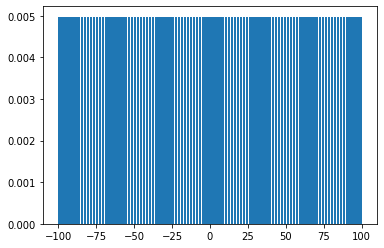

In [14]:
vmin, vmax = -100., 100.
nsup = 201
support = np.linspace(vmin,vmax,nsup)
probs = np.ones(nsup)
probs /= probs.sum()
z3 = torch.from_numpy(probs).float()
plt.bar(support,probs)

In [15]:
def update_dist(r, support, probs, lim=(-100.,100.), gamma=0.8):
    nsup = probs.shape[0]
    dz = (vmax-vmin)/(nsup-1.)
    bj = np.round((r-vmin)/dz)
    bj = int(np.clip(bj, 0, nsup-1))
    m = probs.clone()
    j = 1
    for i in range(bj, 1, -1):
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj, nsup -1, 1):
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum()
    return m

In [16]:
def dist_dqn(x, theta, aspace=5):
    dim0, dim1, dim2, dim3 = 845, 250, 100, 201
    t1 = dim0 * dim1
    t2 = dim2 * dim1
    theta1 = theta[0:t1].reshape(dim0, dim1)
    theta2 = theta[t1:t1 + t2].reshape(dim1, dim2)
    l1 = x @ theta1
    l1 = torch.selu(l1)
    l2 = l1 @ theta2
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace):
        step = dim2 * dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2, dim3)
        l3_ = l2 @ theta5
        l3.append(l3_)
    l3 = torch.stack(l3, dim=1)
    l3 = torch.nn.functional.softmax(l3, dim=2)
    return l3.squeeze()

In [17]:
def lossfn(x, y):
    loss = torch.Tensor([0.])
    loss.requires_grad = True
    for i in range(x.shape[0]): 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
    return loss

In [18]:
def get_target_dist(dist_batch, action_batch, reward_batch, support, lim=(-100,100), gamma=0.8):
    nsup = support.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]):
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1:
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else:
            target_dist = update_dist(r, support, dist, lim=lim, gamma=gamma)
        target_dist_batch[i,action,:] = target_dist
        
    return target_dist_batch

In [19]:
def preproc_state(state):
    p_state = torch.from_numpy(state.astype(np.float32)).unsqueeze(dim=0)
    p_state = torch.nn.functional.normalize(p_state, dim=1)
    return p_state

def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]):
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])]
        action = int(np.argmax(expectations))
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [20]:
import gym
from collections import deque
env = RoutingEnv()
aspace = 5

vmin, vmax = -100, 100
replay_size = 50000
batch_size = 256
nsup = 201
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,  vmax,nsup)

replay = deque(maxlen=replay_size)
lr = 0.0001 
gamma = 0.1
epochs = 4000
eps = 0.50
eps_min = 0.05
priority_level = 5
update_freq = 64

tot_params = 845*250 + 100*250 + aspace*100*201 
theta = torch.randn(tot_params)/100.
theta.requires_grad = True
theta_2 = theta.detach().clone()

losses = []
cum_rewards = []
renders = []
state = preproc_state(env.reset())

Epoch: 0, Reward: 18.153846153846153
Epoch: 1, Reward: 18.153846153846153
Epoch: 2, Reward: 14.224852071005918
Epoch: 3, Reward: 12.721893491124261
Epoch: 4, Reward: 12.402366863905325
Epoch: 5, Reward: 12.153846153846153
Epoch: 6, Reward: 8.224852071005918
Epoch: 7, Reward: 5.313609467455621
Epoch: 8, Reward: 4.402366863905326
Epoch: 9, Reward: 3.4911242603550297
Epoch: 10, Reward: 3.4911242603550297
Epoch: 11, Reward: -0.1893491124260355
Epoch: 12, Reward: -0.5443786982248521
Epoch: 13, Reward: -1.7514792899408285
Epoch: 14, Reward: -3.337278106508876
Epoch: 15, Reward: -4.1301775147929
Epoch: 16, Reward: 18.153846153846153
Epoch: 17, Reward: 15.065088757396449
Epoch: 18, Reward: 13.337278106508876
Epoch: 19, Reward: 13.005917159763314
Epoch: 20, Reward: 11.928994082840237
Epoch: 21, Reward: 11.431952662721894
Epoch: 22, Reward: 11.195266272189349
Epoch: 23, Reward: 10.08284023668639
Epoch: 24, Reward: 4.106508875739645
Epoch: 25, Reward: 4.106508875739645
Epoch: 26, Reward: 3.644970

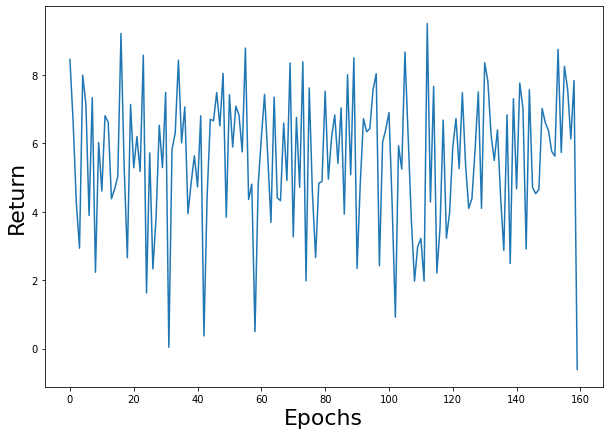

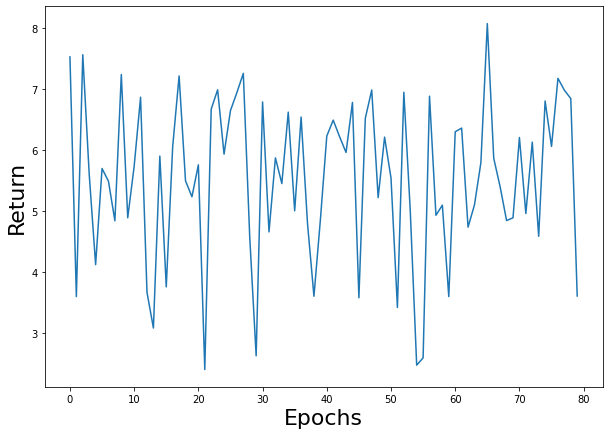

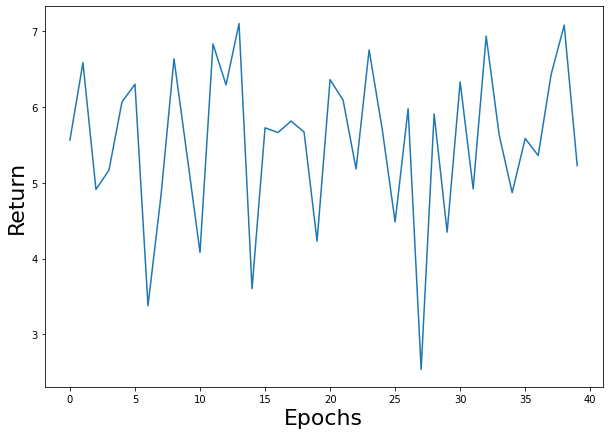

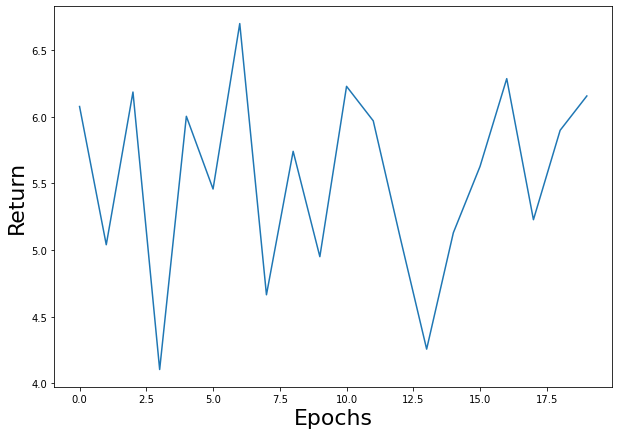

In [21]:
from random import shuffle
for i in range(epochs):
    pred = dist_dqn(state.reshape(1, 845), theta, aspace=aspace)
    if i < replay_size or np.random.rand(1) < eps:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
    state2, reward, done, info = env.step(action)
    print("Epoch: {}, Reward: {}".format(i, reward))
    state2 = preproc_state(state2)
    cum_rewards.append(reward) 
    exp = (state, action, reward, state2)
    replay.append(exp)
    
    if reward > 0:
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size:
        indx = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps], dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps], dim=1).squeeze()
        pred_batch = dist_dqn(state_batch.detach().reshape(batch_size, 845), theta, aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach().reshape(batch_size, 845), theta_2, aspace=aspace)
        target_dist = get_target_dist(pred2_batch, action_batch, reward_batch, \
                                     support, lim=(vmin,vmax), gamma=gamma)
        loss = lossfn(pred_batch, target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        with torch.no_grad():
            theta -= lr * theta.grad
        theta.requires_grad = True
        
    if i % update_freq == 0:
        theta_2 = theta.detach().clone()
        
    if i > 100 and eps > eps_min:
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done:
        state = preproc_state(env.reset())
        done = False

sizes = [25, 50, 100, 200]
for size in sizes:
    avg = []
    for idx in range(0, len(cum_rewards), size):
        avg += [sum(val for val in cum_rewards[idx:idx + size]) / size]

    plt.figure(figsize=(10,7))
    plt.plot(avg)
    plt.xlabel("Epochs",fontsize=22)
    plt.ylabel("Return",fontsize=22)
    plt.savefig('avg_return_{}.png'.format(size))

# **Dueling DQN**

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(845, 1500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1500, 700)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(700, 200)
        self.fc_adv = nn.Linear(700, 200)

        self.value = nn.Linear(200, 1)
        self.adv = nn.Linear(200, 5)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        y = self.relu(self.fc2(y))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


env = RoutingEnv()
n_state = 845
n_action = 5

onlineQNetwork = QNetwork().to(device)
targetQNetwork = QNetwork().to(device)
targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)

GAMMA = 0.99
EXPLORE = 20000
INITIAL_EPSILON = 0.5
FINAL_EPSILON = 0.0001
REPLAY_MEMORY = 50000
BATCH = 256

UPDATE_STEPS = 4

memory_replay = Memory(REPLAY_MEMORY)

epsilon = INITIAL_EPSILON
learn_steps = 0
begin_learn = False

episode_reward = 0
total_rewards = []

for epoch in range(400):
    state = env.reset()
    _state = torch.flatten(torch.from_numpy(state.astype(np.float32))).reshape(1, n_state)
    episode_reward = 0
    for time_steps in range(200):
        p = random.random()
        if p < epsilon:
            action = random.randint(0, n_action-1)
        else:
            tensor_state = _state.to(device)
            action = onlineQNetwork.select_action(tensor_state)
        next_state, reward, done, _ = env.step(action)
        _next_state = torch.flatten(torch.from_numpy(next_state.astype(np.float32))).reshape(1, n_state)
        episode_reward += reward
        memory_replay.add((_state, _next_state, action, reward, done))
        if memory_replay.size() > 256:
            if begin_learn is False:
                print('learn begin!')
                begin_learn = True
            learn_steps += 1
            if learn_steps % UPDATE_STEPS == 0:
                targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
            batch = memory_replay.sample(BATCH, False)
            batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)


            batch_state = torch.cat([item for item in batch_state]).to(device)
            batch_next_state = torch.cat([item for item in batch_next_state]).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():
                onlineQ_next = onlineQNetwork(batch_next_state)
                targetQ_next = targetQNetwork(batch_next_state)
                online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
                y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

            loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        if done:
            total_rewards.append(episode_reward)
            break
        state = next_state

    if epoch % 10 == 0:
        torch.save(onlineQNetwork.state_dict(), 'ddqn-policy.para')
        print('Ep {}\tMoving average score: {:.2f}\t'.format(epoch, episode_reward))
print(total_rewards)

Ep 0	Moving average score: 115.72	
Ep 10	Moving average score: 94.46	
learn begin!
Ep 20	Moving average score: 119.88	
Ep 30	Moving average score: 95.82	
Ep 40	Moving average score: 80.54	
Ep 50	Moving average score: 90.46	
Ep 60	Moving average score: 49.76	
Ep 70	Moving average score: 60.27	
Ep 80	Moving average score: 114.60	
Ep 90	Moving average score: 43.10	
Ep 100	Moving average score: 88.05	
Ep 110	Moving average score: 95.42	
Ep 120	Moving average score: 108.63	
Ep 130	Moving average score: 54.66	
Ep 140	Moving average score: 91.44	
Ep 150	Moving average score: 94.33	
Ep 160	Moving average score: 93.56	
Ep 170	Moving average score: 30.73	
Ep 180	Moving average score: 65.59	
Ep 190	Moving average score: 114.85	
Ep 200	Moving average score: 136.12	
Ep 210	Moving average score: 160.71	
Ep 220	Moving average score: 110.75	
Ep 230	Moving average score: 116.09	
Ep 240	Moving average score: 54.84	
Ep 250	Moving average score: 146.99	
Ep 260	Moving average score: 129.24	
Ep 270	Moving a

In [74]:
class DRLEngine():
    def __init__(self):
        self.graph = nx.Graph()
        self.link_bw_capacity = {}
        self.current_link_bw = {}
        self.hosts = {}
        self.paths = {}
        self.host_pairs = [('H1', 'H13'), ('H2', 'H9'), ('H4', 'H10'), ('H3', 'H6'), ('H5', 'H4'), ('H3', 'H12'), ('H1', 'H7'), ('H7', 'H4'),
                            ('H1', 'H8'), ('H2', 'H5'), ('H4', 'H13'), ('H3', 'H4'), ('H5', 'H12'), ('H3', 'H9'), ('H1', 'H5'), ('H7', 'H13')]
        self.requests_bw = [5, 10, 15, 20]

        self.upload_topology()
        self.build_graph()
        self.calculate_paths()

    def upload_topology(self):
        with open(TOPOLOGY_ARPANET_FILE_NAME, 'r') as topo:
            for row in topo.readlines():
                row_data = row.split()
                if 'H' in row_data[0]:
                    self.hosts[row_data[0]] = row_data[1].replace("S", "")
                elif 'S' in row_data[0]:
                    src_id = row_data[0].replace("S", "")
                    dst_id = row_data[1].replace("S", "")

        self.current_link_bw = copy.deepcopy(self.link_bw_capacity)

    def build_graph(self):
        with open(TOPOLOGY_ARPANET_FILE_NAME, 'r') as topo:
            for line in topo.readlines():
                nodes = line.split()[:2]
                for node in nodes:
                    if not self.graph.has_node(node):
                        self.graph.add_node(node)
                self.graph.add_edge(nodes[0], nodes[1])
    
    def k_shortest_paths(self, graph, source, target, k):
        try: 
            calc = list(islice(nx.shortest_simple_paths(graph, source, target), k))
        except nx.NetworkXNoPath:
            calc = []
            
        return [path for path in calc]

    def calculate_paths(self):
        for src_host_id in range(1, NUMBER_OF_HOSTS+1):
            src = "H{}".format(src_host_id)
            for dst_host_id in range(1, NUMBER_OF_HOSTS+1):
                dst = "H{}".format(dst_host_id)
                if self.graph.has_node(src) and self.graph.has_node(dst):
                    self.paths[(src, dst)] = self.k_shortest_paths(self.graph, src, dst, NUMBER_OF_PATHS)
                    for path in self.paths[(src, dst)]:
                        if len(path) != 0:
                            for i in range(0, len(path)):
                                if "S" in path[i]:
                                    path[i] = path[i].replace("S", "")
                                    path[i] = int(path[i])

    def make_reservation(self, path_id):
        random.shuffle(self.host_pairs)
        pair = self.host_pairs.pop(0)
        path = self.paths[(pair[0], pair[1])][path_id][1:-1]
        request_bw = 15
        # request_bw = self.requests_bw[random.randint(0, 3)]

        for s1, s2 in zip(path[:-1], path[1:]):
            if self.current_link_bw.get((str(s1), str(s2))):
                self.current_link_bw[(str(s1), str(s2))] -= request_bw
                if self.current_link_bw[(str(s1), str(s2))] == 0:
                    self.current_link_bw[(str(s1), str(s2))] = 1
            if self.current_link_bw.get((str(s2), str(s1))):
                self.current_link_bw[(str(s2), str(s1))] -= request_bw
                if self.current_link_bw[(str(s2), str(s1))] == 0:
                    self.current_link_bw[(str(s2), str(s1))] = 1


    def build_state(self):
        state = np.empty((NUMBER_OF_HOSTS, NUMBER_OF_HOSTS, NUMBER_OF_PATHS, 1), dtype=object)
        
        for src in range(1, NUMBER_OF_HOSTS+1):
            h_src = "H{}".format(src)
            for dst in range(1, NUMBER_OF_HOSTS+1):
                h_dst = "H{}".format(dst)
                min_value = float('Inf')
                cnt = 0
                if len(self.paths[(h_src, h_dst)]) == 1:
                    if self.paths[(h_src, h_dst)] == []:
                        for idx in range(NUMBER_OF_PATHS):
                            state[src-1, dst-1, idx] = 1
                    else: 
                        state[src-1, dst-1, 0] = 100
                        for idx in range(1, NUMBER_OF_PATHS):
                            state[src-1, dst-1, idx] = 1
                else:
                    for path in self.paths[(h_src, h_dst)]:
                        path = path[1:-1]
                        for s1, s2 in zip(path[:-1], path[1:]):
                            stats = self.current_link_bw.get((str(s1), str(s2)))
                            if stats:
                                if float(stats) < float(min_value):
                                    min_value = self.current_link_bw[(str(s1), str(s2))]
                    
                        state[src-1, dst-1, cnt] = float(min_value)
                        cnt += 1
                        
                    for idx in range(len(self.paths[(h_src, h_dst)]), NUMBER_OF_PATHS):
                        state[src-1, dst-1, idx] = 1
                    
        return state

    def reset(self):
        self.graph = nx.Graph()
        self.host_pairs = [('H1', 'H13'), ('H2', 'H9'), ('H4', 'H10'), ('H3', 'H6'), ('H5', 'H4'), ('H3', 'H12'), ('H1', 'H7'), ('H7', 'H4'),
                           ('H1', 'H8'), ('H2', 'H5'), ('H4', 'H13'), ('H3', 'H4'), ('H5', 'H12'), ('H3', 'H9'), ('H1', 'H5'), ('H7', 'H13')]
        self.current_link_bw = copy.deepcopy(self.link_bw_capacity)

In [78]:
eng = DRLEngine()

for conn in list(eng.graph.edges()):
    eng.current_link_bw[conn] = 100


print(eng.current_link_bw)

{('H1', 'S1'): 100, ('S1', 'S2'): 100, ('S1', 'S6'): 100, ('S1', 'S3'): 100, ('H2', 'S2'): 100, ('S2', 'S4'): 100, ('S2', 'S5'): 100, ('H3', 'S3'): 100, ('S3', 'S7'): 100, ('S3', 'S8'): 100, ('H4', 'S4'): 100, ('S4', 'S5'): 100, ('S4', 'S11'): 100, ('H5', 'S8'): 100, ('S8', 'S9'): 100, ('S8', 'S10'): 100, ('S8', 'S12'): 100, ('H6', 'S11'): 100, ('S11', 'S9'): 100, ('S11', 'S13'): 100, ('H7', 'S12'): 100, ('S12', 'S14'): 100, ('S12', 'S19'): 100, ('H8', 'S13'): 100, ('S13', 'S15'): 100, ('S13', 'S17'): 100, ('H9', 'S16'): 100, ('S16', 'S15'): 100, ('S16', 'S18'): 100, ('S16', 'S19'): 100, ('H10', 'S17'): 100, ('S17', 'S19'): 100, ('S17', 'S20'): 100, ('H11', 'S18'): 100, ('S18', 'S14'): 100, ('H12', 'S19'): 100, ('S19', 'S10'): 100, ('S19', 'S20'): 100, ('H13', 'S20'): 100, ('S20', 'S14'): 100, ('S6', 'S5'): 100, ('S6', 'S7'): 100, ('S7', 'S10'): 100, ('S10', 'S9'): 100, ('S14', 'S15'): 100}


In [14]:
import numpy as np

results = []
for i in range(20):
    results.append(np.random.poisson(3))

print(results)

[0, 6, 1, 4, 1, 2, 5, 1, 3, 2, 7, 3, 3, 3, 1, 4, 3, 2, 3, 4]
